In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.io_utils import load_data
import src.functions as F
from src.healthanalyzer import HealthAnalyzer

df = load_data("data/health_study_dataset.csv")
analyzer = HealthAnalyzer(df)

## Beskrivande analys

In [ ]:
analyzer.summary_data(["age"])
analyzer.summary_data(["weight"])
analyzer.summary_data(["height"])
analyzer.summary_data(["systolic_bp"])
analyzer.summary_data(["cholesterol"])

fig, ax = plt.subplots(figsize=(9, 4))
analyzer.plot_hist(ax, ["systolic_bp"], "Frequency of systolic BP", "Systolic BP (mmHg)", "Frequency")
plt.savefig("images/fig_hist_BP", dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
analyzer.boxplot_by_group(ax, "weight", "sex", "Distribution of weight by gender", "Weight (kg)", "Gender (Female/Male)")
plt.suptitle("")
plt.savefig("images/fig_boxplot_weight_sex", dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
analyzer.plot_barchart(ax, "smoker", "Distribution of smokers", "Smoker")
plt.xticks(rotation=0)
plt.savefig("images/fig_bar_smokers", dpi=200)
plt.show()

## Simulering kopplat till caset

In [ ]:
analyzer.simulating_proportions("disease", 1000)

**Tolkning:** Simuleringen visar att om den sanna andelen sjuka i populationen är 5.9% så kan ett stickprov på 1000 personer ge en observerad andel på 5.6% på grund av slumpmässig variation.

## Konfidensintervall för systoliskt blodtryck
- Valde att göra normalapproximation med hjälp av t-fördelning då populationsstandardavvikelse är okänd.
- Konfidensintervallet blir litet då vi har ett stort stickprov med litet spridning (liten standardavvikelse)
- Uträkning med bootstrap gav ett snävare intervall vilket kan tyda på mer precis uträkning men kan också bero på att bootstrapen underskattar osäkerheten. Normalapproximation är mer konservativ.
- Källa: Business Statistics av Jaggia & Kelly (2021)

In [ ]:
low, high = F.conf_intervall(df["systolic_bp"])
low_boot, high_boot = F. ci_mean_bootstrap(df["systolic_bp"])
mean_systolic_bp = df["systolic_bp"].mean()

print(f"""
Mean for systolic BP                : {mean_systolic_bp:.2f} mmHg
95% CI with normal approximation    : ({low:.2f}, {high:.2f})
95% CI with bootstrap               : ({low_boot:.2f}, {high_boot:.2f})
""")



Mean for systolic BP                : 149.18
95% CI with normal approximation    : (148.29, 150.07)
95% CI with bootstrap               : (148.30, 150.06)



## Hypotesprövning
H₀: medelvärde för bloodtryck hos rökare = medelvärde för bloodtryck hos icke-rökare    
H₁: medelvärde för bloodtryck hos rökare > medelvärde för bloodtryck hos icke-rökare

- Vi gör ett ensidigt Welch's t-test då varianserna för våra två grupper inte kan antas lika (equal_var=False).
- Vi räknar ut ett konfidensintervall för skillnaden i medelvärden med hjälp av t-fördelningen.
- Källor: Scipy docs: stats.ttest_ind och Business Statistics, Jaggia & Kelly (2021)

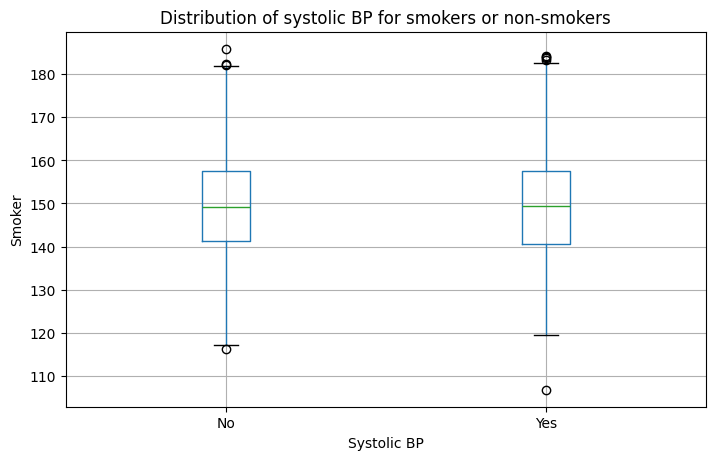


--- One-sided t-test: systolic BP for smokers > systolic BP fon non-smokers ---
Mean Systolic BP för smokers                : 149.52
Mean Systolic BP for non-smokers            : 149.05
Difference between means                    : 0.47
t-stats                                     : 0.450
p-value (one-sided)                         : 0.326
CI 95% for the difference between the means : -1.589, 2.533          



In [6]:
from statsmodels.stats.api import DescrStatsW
from statsmodels.stats.api import CompareMeans
from scipy import stats

bp_smoker = df[df["smoker"] == "Yes"]["systolic_bp"]
bp_no_smoker = df[df["smoker"] == "No"]["systolic_bp"]

t_stat, p_value = stats.ttest_ind(bp_smoker, bp_no_smoker, equal_var=False, alternative="greater")
res = CompareMeans(DescrStatsW(bp_smoker), DescrStatsW(bp_no_smoker))
low_ci_diff, high_ci_diff = res.tconfint_diff(alpha=0.05, usevar="unequal")

fig, ax = plt.subplots(figsize=(8, 5))
analyzer.boxplot_by_group(ax, "systolic_bp", "smoker", "Distribution of systolic BP for smokers or non-smokers", "Systolic BP", "Smoker")
plt.suptitle("")
plt.show()

print(f"""
--- One-sided t-test: systolic BP for smokers > systolic BP fon non-smokers ---
Mean Systolic BP för smokers                : {bp_smoker.mean():.2f}
Mean Systolic BP for non-smokers            : {bp_no_smoker.mean():.2f}
Difference between means                    : {bp_smoker.mean() - bp_no_smoker.mean():.2f}
t-stats                                     : {t_stat:.3f}
p-value (one-sided)                         : {p_value:.3f}
CI 95% for the difference between the means : {low_ci_diff:.3f}, {high_ci_diff:.3f}          
""")


**Tolkning**: 

- p-värdet > 0.05 vilket gör att vi inte kan förkasta nollhypotesen vid signifikansnivå 95%.
- Konfidensintervallet innehåller 0 vilket också visar att vi inte kan förkasta nollhypotesen
- Detta innebär att det **inte finns tillräckligt statistikt stöd** för att rökare har högre medelblodtryck än icke-rökare

## Power

- Valde mellan NormalIndPower() och TTestIndPower(). Den senare används när varianserna är lika eller kan anses lika. Då vi inte har antagit lika varians tidigare väljs istället NormalIndPower() för att beräkna power baserat på normalapproximation. 
- NormIndPower() kan användas när vi har normalfördelad data eller tillräckligt stora stickprov där t-fördelningen nästan är lika med normalfördelningen. Vi har två stickprov med ca 200 respektive 550 observationer vilket kan anses som tillräckligt stora.

- Källa: Statsmodels docs: stats.power.TTestIndPower, stats.power.NormalIndPower och Business Statistics, Jaggia & Kelly (2021)

In [ ]:
from statsmodels.stats.power import NormalIndPower

mean1 = bp_smoker.mean()
mean2 = bp_no_smoker.mean()
sd1, sd2 = bp_smoker.std(ddof=1), bp_no_smoker.std(ddof=1)
d_welch = (mean1 - mean2) / np.sqrt((sd1**2 + sd2**2) / 2)
alpha = 0.05
n_smoker = len(bp_smoker)
n_no_smoker = len(bp_no_smoker)
ratio = n_no_smoker / n_smoker

solver = NormalIndPower()

power = solver.power(effect_size=d_welch,
                                nobs1=n_smoker,
                                alpha=alpha,
                                ratio=ratio,
                                alternative="two-sided")


print(f"Power (normalapproximation) ≈ {power:.3f}")

**Tolkning:** Att power blir så lågt (0.074) innebär att sannolikheten att upptäcka verklig skillnad i blodtryck mellan rökare och icke-rökar är **mycket liten** med det aktuella datamaterialet

## Regressionsanalys

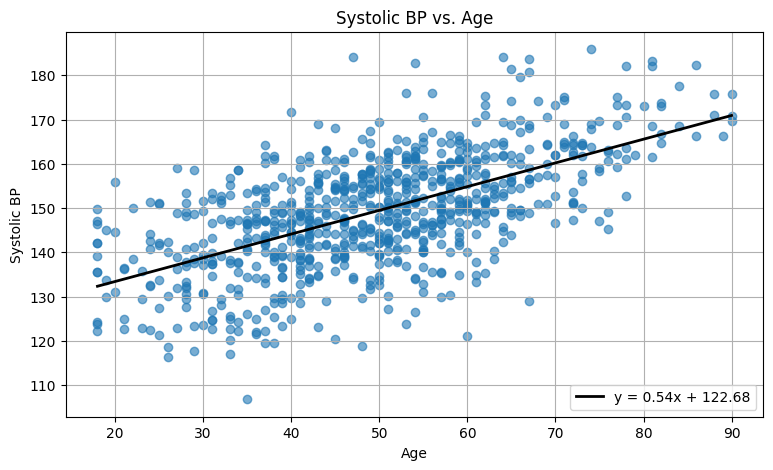

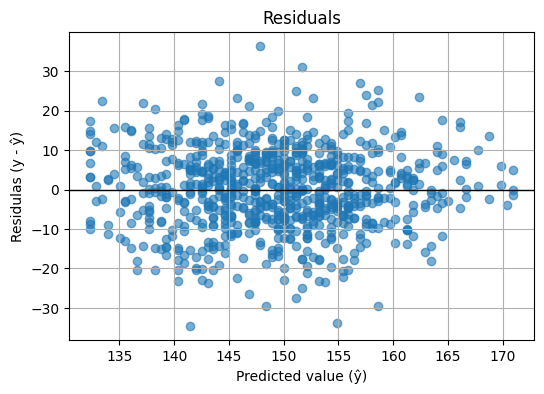


------------ Regression: Age vs. Systolic BP ------------
Intercept   : 122.68
Slope       : 0.54
R²          : 0.369
Predicted systolic BP at age 60 using our regression-model: 154.8
Interpretation slope: +10 years => blood pressure increase by 5.36



In [3]:
intercept_hat, slope_hat, r2, y_hat, residuals = F.regression(df, "age", "systolic_bp")

fig, ax = plt.subplots(figsize=(9, 5))
analyzer.plot_scatter(ax, "age", "systolic_bp", "Systolic BP vs. Age", "Age", "Systolic BP")
x_line = np.linspace(df["age"].min(), df["age"].max(), 100)
y_line = intercept_hat + slope_hat * x_line
ax.plot(x_line, y_line, color="black", linewidth=2, label=rf"y = {slope_hat:.2f}x + {intercept_hat:.2f}")
ax.legend(loc="lower right")
plt.savefig("images/fig_reg_BP_age", dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
F.plot_scatter(ax, y_hat, residuals, "Residuals", "Predicted value (ŷ)", "Residulas (y - ŷ)")
ax.axhline(0, color="black", linewidth=1)
plt.show()

predicted_y_60 = F.regression_prediction(60, intercept_hat, slope_hat)

print(f"""
------------ Regression: Age vs. Systolic BP ------------
Intercept   : {intercept_hat:.2f}
Slope       : {slope_hat:.2f}
R²          : {r2:.3f}
Predicted systolic BP at age 60 using our regression-model: {predicted_y_60:.1f}
Interpretation slope: +10 years => blood pressure increase by {10*slope_hat:.2f}
""")


**Tolkning:** Baserat på regressionsanalysen ses systoliskt bloodtryck öka med åldern. Det finns en korrelation mellan bloodtryck och åldern dock säger resultaten ingeting om kausalitet. Vårt R²-värde visar att ca 37% av variationen i blodtryck kan förklaras av ålder, modellen har en måttlig förklaringsgrad. Troligtvis finns det också en korrelation mellan blodtryck och genetik, livstil osv. som modellen inte fångar. 
- Källa: Statistik och regression i praktiken, Ruist (2021)

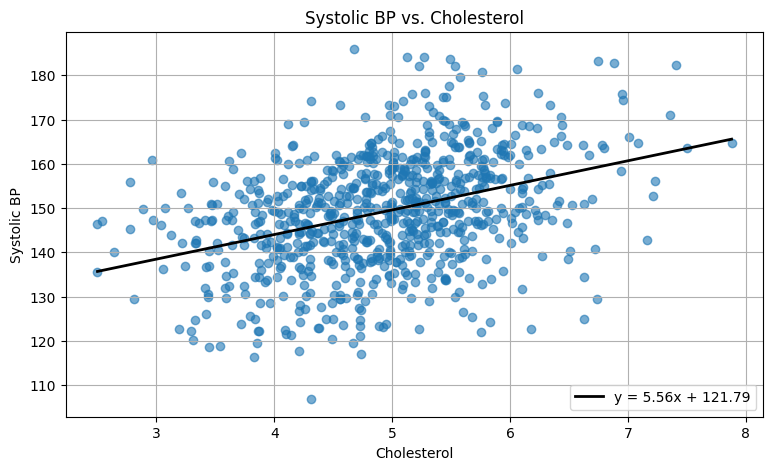

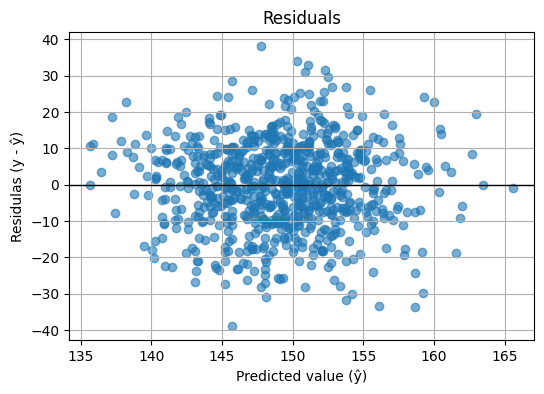


------------ Regression: Systolic BP vs. Cholesterol ------------
Intercept   : 121.79
Slope       : 5.56
R²          : 0.136

Interpretation slope: +1 mmol/L => blood pressure increase by 5.56 mmHg



In [4]:
intercept_hat_chol_sys, slope_hat_chol_sys, r2_chol_sys, y_hat_chol_sys, residuals_chol_sys = F.regression(df, "cholesterol", "systolic_bp")
fig, ax = plt.subplots(figsize=(9, 5))
analyzer.plot_scatter(ax, "cholesterol", "systolic_bp", "Systolic BP vs. Cholesterol", "Cholesterol", "Systolic BP")
x_line = np.linspace(df["cholesterol"].min(), df["cholesterol"].max(), 20)
y_line = intercept_hat_chol_sys + slope_hat_chol_sys * x_line
ax.plot(x_line, y_line, color="black", linewidth=2, label=rf"y = {slope_hat_chol_sys:.2f}x + {intercept_hat_chol_sys:.2f}")
ax.legend(loc="lower right")
plt.savefig("images/fig_reg_BP_chol", dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
F.plot_scatter(ax, y_hat_chol_sys, residuals_chol_sys, "Residuals", "Predicted value (ŷ)", "Residulas (y - ŷ)")
ax.axhline(0, color="black", linewidth=1)
plt.show()

print(f"""
------------ Regression: Systolic BP vs. Cholesterol ------------
Intercept   : {intercept_hat_chol_sys:.2f}
Slope       : {slope_hat_chol_sys:.2f}
R²          : {r2_chol_sys:.3f}

Interpretation slope: +1 mmol/L => blood pressure increase by {slope_hat_chol_sys:.2f} mmHg
""")

**Tolkning:** Baserat på regressionsanalysen ses systoliskt bloodtryck öka när kolesterol ökar dock är R²-värdet 0.136 vilket innebär att bara ca 14% av variationen i blodtryck kan förklaras av kolesterol. Modellen har därför en låg förklaringsgrad. Detta ses också om man jämför residual-graferna för de två regressionsanalyserna. För första regressionen, blodtryck vs. ålder, ses residualerna ligga mer klumpade runt nollan än i den senare grafen, blodtryck vs. kolesterol. 
- Källa: Statistik och regression i praktiken, Ruist (2021)

## Multiple regression
För att undersöka hur blodtryck korrelerar med ålder, vikt och kolesterol.

In [5]:
from statsmodels.formula.api import ols

formula = "systolic_bp ~ age + weight + cholesterol"
model = ols(formula=formula, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            systolic_bp   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     181.2
Date:                Fri, 28 Nov 2025   Prob (F-statistic):           1.50e-89
Time:                        12:46:09   Log-Likelihood:                -2965.6
No. Observations:                 800   AIC:                             5939.
Df Residuals:                     796   BIC:                             5958.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     108.5107      2.536     42.796      

**Slutsats:** 
- Vårt justerade R²-värdet visar att ca 40% av variationen i bloodtryck kan föklaras av ålder, vikt och kolesterol. I medicinska och biologisk data, där många komplex faktorer spelar in, kan 40% ses som ett högt värde. 
- Intercept är det förväntade värdet på bloodtryck när de andra variablerna är 0. Svårt att dra några slutsatser från det då ålder, vikt och kolesterol aldrig är 0 i verkligheten. 
- Ålder: koefficienten är ca 0.53 vilket innebär att blodtrycket ökar med 0.53 mmHg när ålder ökar med 1 år men vikt och kolesterol hålls konstanta. p-värdet < 0.05 så ålder har en statistiskt signifikant effekt på blodtryck, även efter att ha tagt hänsyn till personens vikt och kolesterol. 
- Vikt: har också en signifikant effekt på blodtryck då p-värden också där är mindre än 0.05. Koefficienten är ca 0.17.
- Kolesterol: koefficient är ca 0.43 men p-värdet är 0.385 så kolesterol ses inte ha en signifikant effekt på blodtryck. 
- Då alla variabler har olika enheter kan inte koefficienterna jämföras med varandra för att se vilket variabel som har störst påverkan på blodtrycket.

- Källa: Statistik och regression i praktiken, Ruist (2021)